# Fractal in Biology

This notebook makes numerical experiment on the emergence of fractal in nature. It is inspired by [West, et al. (1997)](https://www.science.org/doi/10.1126/science.276.5309.122). This paper concludes that fractal in biology results in the minimization of total energy cost. In the specific case considered by the authors, the mammalian circulatory systems, the fractal branching of capillary vessel naturally arises from reducing the energy cost of vessel circulation. This numerical experiment gives us some hint about how fractal emerges in nature.

In this notebook, we adjust some strange assumptions in West's paper. We further apply the computation here to West's original assumptions, discussed in the notebook _Fractal in Biology (West 1997)_.

## Notations

We follow the notations:

- $C$: number of branching levels.
- $k$: branching level, from $0$ to $C$.
- $n_k$: number of branches at $k$ level.
- $r_k$: radius of vessel at $k$ level.
- $l_k$: length of vessel at $k$ level.
- $\nu_k$: $n_{k+1} / n_k$.
- $\rho_k$: $r_{k+1} / r_k$.
- $\lambda_k$: $l_{k+1} / l_k$.

## Assumptions

The assumption that the properties of capillary are universal for all mammals implies that the $l_C$, and $r_C$ are fixed. Also, $n_0=1$. So, we have

$$ l_k = \frac{l_k}{l_{k+1}} \cdots \frac{l_{C-1}}{l_C} l_C = l_C \lambda_k^{-1} \cdots \lambda_{C-1}^{-1} = l_C \prod_{i=k}^{C-1} \lambda_i^{-1}. $$

The same,

$$ r_k = r_C \prod_{i=k}^{C-1} \rho_i^{-1}. $$

But,

$$ n_k = n_0 \frac{n_1}{n_0} \cdots \frac{n_k}{n_{k-1}} = \prod_{i=0}^{k-1} \nu_i. $$

Based on assumption of area-preserving, we have that $n_k r_k^2$ is independent of $k$. This implies

$$ \rho_k = \nu_k^{-1/2}. $$

And by assumption of space-fulfilling, we have that $n_k l_k^3$ is independent of $k$. This implies

$$ \lambda_k = \nu_k^{-1/3}. $$

Because of these, the unique degree of freedom is the $\nu$.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python import keras
from tqdm import tqdm
import matplotlib.pyplot as plt

2024-03-03 20:24:28.002481: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


We use several samples in searching optimal parallelly. So, the $\nu$, or for numerical stability $\ln \nu$, has tensor shape `[samples, levels]`.

In [2]:
EXPERIMENT = {
    'samples': 100,
    'levels': 10,
}

## Loss Function

The quantity to be minimized is the total resistance of the vessel system. By [Hagen-Poiseuille equation](https://en.wikipedia.org/wiki/Hagen%E2%80%93Poiseuille_equation#Equation), we have the difference of pressure at level $k$, $\Delta p_k = Q_k R_k$ where $Q_k$ represents the flow rate and $R_k := (8 \mu l_k)/(\pi r_k^4)$. Analogy to electricity, $\Delta p_k$ corresponds to difference of potential $\Delta V$, and $Q_k$ to current $I$. So, the $R_k$ is the resistance. At level $k$, the vessels are parallel. And for different levels, vessels are serial. So, the total resistance comes to be

$$ R_b = \sum_{k=0}^{C} \frac{R_k}{n_k} = \frac{8\mu}{\pi} \sum_{k=0}^{C} \frac{l_k}{r_k^4 n_k} = \frac{8\mu}{\pi} \frac{l_C}{r_C^4} \sum_{k=0}^{C} \left( \prod_{i=k}^{C-1} \frac{\rho_i^4}{\lambda_i} \right) \left( \prod_{i=0}^{k-1} \frac{1}{\nu_i} \right). $$

Plugging into the relation between $\rho$, $\lambda$ and $\nu$, we find

$$ R_b = \frac{8\mu}{\pi} \frac{l_C}{r_C^4} \sum_{k=0}^{C} \left( \prod_{i=k}^{C-1} \nu_i^{-5/3} \right) \left( \prod_{i=0}^{k-1} \nu_i^{-1} \right). $$

For numerical stability, we consider

$$ \ln R_b = \ln \left( \frac{8\mu}{\pi} \frac{l_C}{r_C^4} \right) + \ln \sum_{k=0}^{C} \left( \prod_{i=k}^{C-1} \nu_i^{-5/3} \right) \left( \prod_{i=0}^{k-1} \nu_i^{-1} \right). $$

In [3]:
def get_log_resistance(log_nu):
    """Omit the constant."""
    logits = []
    for k in range(EXPERIMENT['levels']+1):
        logit_k = (
            -(5/3) * tf.reduce_sum(log_nu[:, k:], axis=1)
            - tf.reduce_sum(log_nu[:, :k], axis=1)
        )
        logits.append(logit_k)
    logits = tf.stack(logits, axis=1)
    return tf.reduce_logsumexp(logits, axis=1)

log_nu = np.log(2) * np.ones([1, EXPERIMENT['levels']])
get_log_resistance(log_nu)

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-5.94354631])>

Because of the space-fulfilling assumption and the assumption that $l_C$ is invariant, the total volume of the mammal, $V_b$, is proportional to $n_C l_C$, which can be expressed as

$$ \ln V_b = \ln l_C + \ln n_C = \ln l_C + \sum_{k=0}^{C-1} \ln \nu_k. $$

In [4]:
def get_log_volume(log_nu):
    """Omit the constant."""
    return tf.reduce_sum(log_nu, axis=1)

get_log_volume(log_nu)

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([6.93147181])>

Since $n_{k+1} \ge n_k$, $\nu_k$ shall be greater than unit. So, there is another constraint that, for each $k$,

$$ \ln \nu_k \ge 0. $$

Altogether, the loss function shall be

$$ \ln R_b(\nu) + \mu \left( \ln V_b(\nu) - \ln \bar{V}_b \right) + \sum_{k=1}^{C-1} \omega_k \left( \ln \nu_k - z_k^2 \right), $$

for some observed values $\bar{V}_b$ given.

What is a proper value of $\bar{V}_b$. It is natural to suppose that $n_{k+1}/n_k \ge 2$. This means $\bar{V}_b$ shall be greater than the volume given by $\nu_k = 2$ for all $k$. And it shall not be too large, for numerical consideration. In fact, adult human has abount $10^{14}$ cells, so $n_C$ shall be smaller than this.

In fact, it is sufficient for the optimized volume to approximate the order of $\bar{V}_b$. We can regard this optimized volume as the real $\bar{V}_b$. In other words, $\bar{V}_b$ is used to determine the order, but not the accurate value.

In [5]:
least_log_volume = get_log_volume(np.log(2) * np.ones([1, EXPERIMENT['levels']]))
most_log_volume = np.log(1e+14)
least_log_volume, most_log_volume

(<tf.Tensor: shape=(1,), dtype=float64, numpy=array([6.93147181])>,
 32.23619130191664)

In [6]:
EXPERIMENT['true_log_volume'] = 3e+1

In [7]:
def get_loss(log_nu, z, mu, omega):
    objective = get_log_resistance(log_nu)
    batch_size = tf.cast(tf.shape(log_nu)[0], log_nu.dtype)
    loss = (
        tf.reduce_sum(objective)
        / batch_size  # average on samples.
    )
    constraints = []
    for multiplier, constraint in [
        (mu, get_log_volume(log_nu) - EXPERIMENT['true_log_volume']),
        (omega, log_nu - tf.square(z)),
        # other constraints......
    ]:
        loss += (
            tf.reduce_sum(multiplier * constraint)
            / batch_size  # also average on samples.
        )
        constraints.append(constraint)
    return objective, constraints, loss

z = tf.ones_like(log_nu)
get_loss(log_nu, z, 0.1, 0.1)

(<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-5.94354631])>,
 [<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-23.06852819])>,
  <tf.Tensor: shape=(1, 10), dtype=float64, numpy=
  array([[-0.30685282, -0.30685282, -0.30685282, -0.30685282, -0.30685282,
          -0.30685282, -0.30685282, -0.30685282, -0.30685282, -0.30685282]])>],
 <tf.Tensor: shape=(), dtype=float64, numpy=-8.55725194484913>)

## Gradient Descent with Constraints

The gradient descent algorithm with constraints is described in [Platt and Barr (1988)](https://papers.nips.cc/paper_files/paper/1987/file/a87ff679a2f3e71d9181a67b7542122c-Paper.pdf). Briefly, descent on the parameters (the $\ln \nu$ here) and ascent on the multipliers (the $\mu$ and $\omega_k$ here). For numerical stability, it is suggested to add an $L_2$-regulation.

For example, consider scalar functions $f$ and $g$ where $f$ is lower bounded. If you want to minimize $f(x)$ with constraint $g(x) = 0$, then the loss function will be

$$ L(x, \mu) = f(x) + \mu g(x), $$

where $\mu$ is the Lagrangian multiplier. Then, optimize the $x$ along the direction

$$ \dot{x}^a = -\nabla^a L(x, \mu) = -\nabla^a f(x) - \mu \nabla^a g(x), $$

where the $\nabla$ is taken on $x$ only. And optimize the $\mu$ along the direction

$$ \dot{\mu} = {\color{red}+} \partial_{\mu} L(x, \mu) = g(x). $$

Indeed, by taking time derivative, we find

$$ \ddot{x}^a + \left( \nabla^a \nabla_b f(x) + \mu \nabla^a \nabla_b g(x) \right) \dot{x}^b + \nabla^a \left( \frac{1}{2} g^2(x) \right) = 0. $$

Analogy to the damped mechanic system, we recognize that the $A^a_b(x) := \nabla^a \nabla_b f(x) + \mu \nabla^a \nabla_b g(x)$ term is a friction coefficient and $g^2(x)$ a potential. So, the energy is $E(x) := (1/2) \dot{x}^2 + (1/2) g^2(x)$, and because of friction, the energy loss rate is $\dot{E}(x) = -A_{a b}(x) \dot{x}^a \dot{x}^b$. So, to ensure that the energy losses, $A(x)$ has to be positive definite, at least being positive definite near the minimum. This is true for $\nabla^a \nabla_b f(x)$ since $f$ is lower bounded. So, we have to restrict the scale of $g$ such that $A$ is positive definite. To do so, we add an $L_2$-regulation for $g(x)$, that is, a term $c g^2(x)$ for a large enough positive constant $c$.

For inequal constraints, like $h(x) \ge 0$, we can add an auxiliary parameter $z$ and set the $g$ as $h(x) - z^2$. In this way, when $g = 0$, $h(x) \ge 0$ is fulfilled. Now, the loss function becomes $L(x, z, \mu) = f(x) + \mu \left( h(x) - z^2 \right)$. The $z$ is optimized in the same way as $x$, that is $\dot{z} = -\nabla_z L(x, z, \mu) = 2 \mu z$. Remark that when $z = 0$, $\dot{z} = 0$ too. Thus $z$ will not be updated and keeps vanishing. This is not what we want. So, at least, $z$ shall not be initialized as $0$ in training.

You may argue that it is the $L_2$-regulation that makes the constraints fulfilled, instead of gradient ascent on the Lagrangian multipliers. So, we add a test for this argument.

In [8]:
EXPERIMENT['test_no_multiplier'] = False  # set $\mu \equiv 0$, thus restricted by L2-regulation only.

In [9]:
def get_train_step(optimizer, l2):
    step = tf.Variable(0, dtype=tf.int32, trainable=False)
    l2 = tf.convert_to_tensor(l2)

    @tf.function
    def train_step(log_nu, z, mu, omega):
        batch_size = tf.cast(tf.shape(log_nu)[0], log_nu.dtype)

        with tf.GradientTape() as tape:
            # Loss:
            if EXPERIMENT['test_no_multiplier']:
                mu = tf.zeros_like(mu)
                omega = tf.zeros_like(omega)
            objective, constraints, loss = get_loss(log_nu, z, mu, omega)

            # L2-regulation:
            l2_regulaition = 0.
            for c in constraints:
                l2_regulaition += l2 * (
                    tf.reduce_sum(tf.square(c))
                    / batch_size  # average on samples.
                )
            loss += l2_regulaition

        # Gradients
        vars = [log_nu, z, mu, omega]
        if EXPERIMENT['test_no_multiplier']:
            vars = [log_nu, z]
        grads = tape.gradient(loss, vars, unconnected_gradients='zero')

        # Descent for parameters and ascent for multipliers:
        grads_and_vars = []
        for i, var in enumerate(vars):
            if i < 2:
                grads_and_vars.append((grads[i], vars[i]))
            else:
                grads_and_vars.append((-grads[i], vars[i]))

        optimizer.apply_gradients(grads_and_vars)
        check_nan(vars)
        step.assign_add(1)
        return objective, constraints, loss, grads_and_vars

    return train_step, step

def check_nan(xs):
    for x in xs:
        try:
            tf.debugging.check_numerics(x, message='')
        except Exception as e:
            raise ValueError('NaN value.')

## Training

Initialize the parameters and Lagrangian multipliers:

In [10]:
log_nu = tf.Variable(
    tf.random.uniform([EXPERIMENT['samples'], EXPERIMENT['levels']],
                      2.0, 4.0)
)
z = tf.Variable(  # z shall not be zero.
    tf.random.uniform([EXPERIMENT['samples'], EXPERIMENT['levels']],
                      0.5, 1.0)
)
mu = tf.Variable(tf.zeros([EXPERIMENT['samples'], 1]))
omega = tf.Variable(tf.zeros([EXPERIMENT['samples'], EXPERIMENT['levels']]))
optimizer = keras.optimizers.adam_v2.Adam(1e-5)
train_step, step = get_train_step(optimizer, 1e-1)

Let us log the objective and constraints before training.

In [11]:
objective, constraints, _, _ = train_step(log_nu, z, mu, omega)
objective, constraints

(<tf.Tensor: shape=(100,), dtype=float32, numpy=
 array([-29.911171, -31.683672, -29.004063, -31.096676, -30.996006,
        -30.010109, -29.509394, -30.155214, -29.625   , -25.436653,
        -28.348978, -31.749067, -31.8857  , -28.862322, -29.998486,
        -29.047522, -31.927204, -30.815168, -30.71717 , -29.979336,
        -30.800436, -28.589367, -30.03633 , -31.526217, -27.893822,
        -33.630154, -31.303165, -33.034073, -30.06322 , -29.37624 ,
        -30.390785, -30.582819, -30.886795, -29.460308, -31.365137,
        -28.136425, -30.149738, -28.573097, -28.764765, -32.30482 ,
        -27.01657 , -33.181026, -27.523933, -31.853283, -32.248974,
        -27.81605 , -29.978003, -31.687546, -27.857435, -30.298822,
        -31.000904, -28.131857, -31.5271  , -29.532007, -28.23612 ,
        -34.2832  , -28.632296, -31.43976 , -28.84251 , -33.023357,
        -32.285946, -29.196165, -30.66077 , -29.447392, -28.967836,
        -29.441147, -26.472937, -29.874573, -32.66243 , -28.136816,

In [12]:
objective_logs = []
loss_logs = []
for i in tqdm(range(500000)):
    objective, _, loss, _ = train_step(log_nu, z, mu, omega)
    objective_logs.append(objective.numpy().mean())
    loss_logs.append(loss.numpy())

100%|██████████████████████████████████████████████████| 500000/500000 [05:50<00:00, 1425.86it/s]


In [13]:
step

<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=500001>

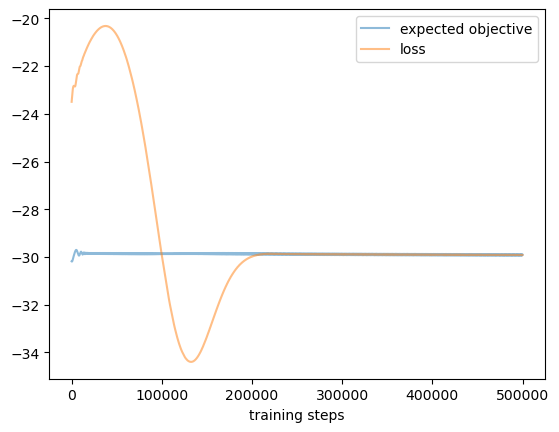

In [14]:
plt.plot(objective_logs, label='expected objective', alpha=0.5)
plt.plot(loss_logs, label='loss', alpha=0.5)
plt.xlabel('training steps')
plt.legend()
plt.show()

Let us check the optimization results:

In [15]:
objective, constraints, _ = get_loss(log_nu, z, mu, omega)

In [16]:
min_i = tf.argmin(objective)
min_i, objective[min_i], [c[min_i] for c in constraints]

(<tf.Tensor: shape=(), dtype=int64, numpy=21>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-29.925974>,
 [<tf.Tensor: shape=(), dtype=float32, numpy=-0.017887115>,
  <tf.Tensor: shape=(10,), dtype=float32, numpy=
  array([-1.0962486e-03,  1.1847019e-03,  9.7298622e-04,  9.4127655e-04,
         -1.1346340e-03,  1.1897087e-03, -3.3140182e-05, -3.5762787e-06,
          5.9914589e-04,  5.9986115e-04], dtype=float32)>])

And for checking fractal:

In [17]:
log_nu[min_i, :]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([3.1962795, 2.4739454, 3.0981777, 2.756678 , 3.1535733, 2.7324555,
       2.0910814, 3.1849167, 2.7657125, 4.5292926], dtype=float32)>

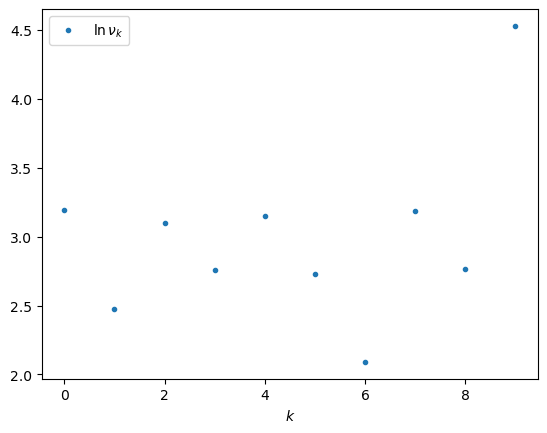

In [18]:
plt.plot(log_nu[min_i, :], '.', label='$\\ln \\nu_k$')
plt.xlabel('$k$')
plt.legend()
plt.show()

In the end, review the hyper-parameters used for this numerical experiment:

In [19]:
EXPERIMENT

{'samples': 100,
 'levels': 10,
 'true_log_volume': 30.0,
 'test_no_multiplier': False}

## Conclusion

* Fractal appears when the `true_log_volume` is sufficient large enough, that is, when the mammalian has sufficient volume or number of cells. This condition can be satisfied by any mammalian.
* If the Lagrangian multiplier is omitted by setting `TEST_NO_MULTIPLIER = True`, we cannot get the constrained result even though $L_2$-regulation has been employed. The Lagrangian multiplier is essential.
* The implementation is not scalable. The CPU usage is quite low.

## How does Fractal Emerge in Nature

Recall that

$$ R_b \propto \sum_{k=0}^{C} \left( \prod_{i=k}^{C-1} \nu_i^{-5/3} \right) \left( \prod_{i=0}^{k-1} \nu_i^{-1} \right). $$

Since $n_C = \prod_{k=0}^{C-1} \nu_k$, when the scale of $n_C$ is sufficient large, the scale of $\nu_k$ may become large too. In this situation, the $k=0$ term dominates the others. Explicitly, it is

$$ \prod_{i=k}^{C-1} \nu_i^{-5/3}. $$

In this expression, the components of $\nu$ are symmetric by permutation. They are equal weight. So, the extreme values of this term has equal components of $\nu$. The same for the constraints. The components of the auxiliary variable $z$ are also symmetric by permutation. So, the extreme values of the loss $L(\nu, z; \mu, \omega)$ have approximately equal components. This is the reason of the emerge of fractal.

In summary, the conditions for fractal to emerge are the large amount of branching and the permutation symmetry in the leading terms of the objective and constraints. When the number of "children branches" becomes large enough for each "parent branch", the differences in the terms of the objective and constraints become so large that only one or several terms dominate. Within these terms, if the permutation symmetry on the branching numbers is satisfied or approximately satisfied, the fractal must emerge.

## Discussion

The resistance $R_b(\nu)$ can be seen as an action. The true value of $\nu$ locates in its minima. So, we can construct a probabilistic model of $\nu$, the branching of vessel system, as

$$ p(\nu) \propto \exp(-\beta R_b(\nu)) \delta(V_b(\nu) - \bar{V}_b), $$

for any positive $\beta$ characterizing the randomness.

TODO